# Initialization

In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.types import DoubleType, IntegerType, StringType
from pyspark.sql.types import StructType, StructField, TimestampType
from pyspark.sql.functions import mean, col, desc, count, isnull, isnan, when, rank, sum
import pandas as pd
import matplotlib.pyplot as plt


spark = SparkSession.builder \
    .appName("MyApp") \
    .config("spark.driver.memory", "8g") \
    .config("spark.executor.memory", "8g") \
    .config("spark.ui.showConsoleProgress", "false") \
    .getOrCreate()

spark.sparkContext.setLogLevel(logLevel='ERROR')

uber_file = "uber-raw-data-aug14.csv"

# schema = StructType([
#     StructField("Date/Time", TimestampType(), True),
#     StructField("Lat", DoubleType(), True),
#     StructField("Lon", DoubleType(), True),
#     StructField("Base", StringType(), True)
# ])

uber = spark.read.format("csv") \
    .option("header", True) \
    .option("inferSchema", True) \
    .load(uber_file)
    # .option("inferSchema", False) \
    # .schema(schema) \



# Description

## Schema

In [2]:
# from pyspark.sql.functions import unix_timestamp, to_timestamp

# uber = uber.withColumn("Date/Time_epoch", to_timestamp(unix_timestamp(col('Date/Time'))))
numeric_columns = [column for column, type in uber.dtypes if type == 'double']
string_columns = [column for column, type in uber.dtypes if type == 'string']

display(uber.dtypes)
uber.printSchema()
print(uber.schema)


[('Date/Time', 'string'),
 ('Lat', 'double'),
 ('Lon', 'double'),
 ('Base', 'string')]

root
 |-- Date/Time: string (nullable = true)
 |-- Lat: double (nullable = true)
 |-- Lon: double (nullable = true)
 |-- Base: string (nullable = true)

StructType([StructField('Date/Time', StringType(), True), StructField('Lat', DoubleType(), True), StructField('Lon', DoubleType(), True), StructField('Base', StringType(), True)])


## Shape

In [3]:
rows_num = uber.count()
cols_num = len(uber.columns)
print("Number of rows: ", rows_num)
print("Number of columns: ", cols_num)


Number of rows:  829275
Number of columns:  4


## Head

In [4]:
uber.show()


+----------------+-------+--------+------+
|       Date/Time|    Lat|     Lon|  Base|
+----------------+-------+--------+------+
|8/1/2014 0:03:00|40.7366|-73.9906|B02512|
|8/1/2014 0:09:00| 40.726|-73.9918|B02512|
|8/1/2014 0:12:00|40.7209|-74.0507|B02512|
|8/1/2014 0:12:00|40.7387|-73.9856|B02512|
|8/1/2014 0:12:00|40.7323|-74.0077|B02512|
|8/1/2014 0:13:00|40.7349|-74.0033|B02512|
|8/1/2014 0:15:00|40.7279|-73.9542|B02512|
|8/1/2014 0:17:00| 40.721|-73.9937|B02512|
|8/1/2014 0:19:00|40.7195| -74.006|B02512|
|8/1/2014 0:20:00|40.7448|-73.9799|B02512|
|8/1/2014 0:21:00|40.7399|-74.0057|B02512|
|8/1/2014 0:25:00|40.7651|-73.9683|B02512|
|8/1/2014 0:27:00|40.7354|-74.0081|B02512|
|8/1/2014 0:29:00|40.7339|-74.0028|B02512|
|8/1/2014 0:29:00|40.7364|-74.0301|B02512|
|8/1/2014 0:29:00|40.7364|-74.0301|B02512|
|8/1/2014 0:30:00|40.7252|-73.9516|B02512|
|8/1/2014 0:30:00|40.7433| -73.986|B02512|
|8/1/2014 0:34:00|40.7437|-73.9884|B02512|
|8/1/2014 0:36:00|40.7406|-74.0077|B02512|
+----------

## Numerical description

In [5]:
# uber.describe().show()
uber.select(numeric_columns).describe().show()


+-------+--------------------+-------------------+
|summary|                 Lat|                Lon|
+-------+--------------------+-------------------+
|  count|              829275|             829275|
|   mean|  40.737780735823705|  -73.9701603131643|
| stddev|0.043628060846870514|0.06148272834516594|
|    min|             39.6569|           -74.7737|
|    max|             41.3182|           -72.3359|
+-------+--------------------+-------------------+



## Distinct values

In [6]:
for column in string_columns:
    print('Number of distinct rows of column %s is %d' % (column, uber.select(column).distinct().count()))
    uber.select(column).distinct().show()


Number of distinct rows of column Date/Time is 44432
+-----------------+
|        Date/Time|
+-----------------+
|8/1/2014 11:36:00|
|8/1/2014 13:42:00|
|8/1/2014 21:42:00|
| 8/2/2014 7:55:00|
|8/2/2014 17:00:00|
|8/2/2014 18:20:00|
|8/2/2014 19:52:00|
| 8/3/2014 0:34:00|
|8/3/2014 10:57:00|
|8/3/2014 15:43:00|
|8/3/2014 20:55:00|
|8/4/2014 11:22:00|
|8/4/2014 13:05:00|
|8/4/2014 15:44:00|
|8/4/2014 20:29:00|
|8/4/2014 22:31:00|
|8/4/2014 22:45:00|
| 8/5/2014 7:46:00|
|8/5/2014 11:10:00|
|8/6/2014 11:02:00|
+-----------------+
only showing top 20 rows

Number of distinct rows of column Base is 5
+------+
|  Base|
+------+
|B02512|
|B02598|
|B02617|
|B02682|
|B02764|
+------+



## 5 nums, mean, mode

In [7]:
for column in numeric_columns:
    mean_value = uber.select(mean(column)).collect()[0][0]
    mode_value = uber.groupBy(column).count().sort(desc("count")).select(col(column)).collect()[0][0]
    
    quantiles = uber.approxQuantile(column, [0.25, 0.5, 0.75], 0.01)
    q1, median, q3 = quantiles[0], quantiles[1], quantiles[2]
    iqr = q3 - q1

    minimum = uber.selectExpr(f"min({column})").collect()[0][0]
    maximum = uber.selectExpr(f"max({column})").collect()[0][0]
    
    print(f"{column}:")
    print(f"mean: {mean_value}")
    print(f"mode: {mode_value}")
    print(f"Minimum: {minimum}")
    print(f"Q1: {q1}")
    print(f"Q2 (Median): {median}")
    print(f"Q3: {q3}")
    print(f"Maximum: {maximum}")
    print(f"IQR: {iqr}")
    print("")


Lat:
mean: 40.737780735823705
mode: 40.6448
Minimum: 39.6569
Q1: 40.7188
Q2 (Median): 40.7405
Q3: 40.7603
Maximum: 41.3182
IQR: 0.041499999999999204

Lon:
mean: -73.9701603131643
mode: -73.9888
Minimum: -74.7737
Q1: -73.9959
Q2 (Median): -73.9829
Q3: -73.9618
Maximum: -72.3359
IQR: 0.034100000000009345



## Count per category

In [8]:
for column in string_columns:
    result = uber.groupBy(column).count().orderBy("count", ascending=False)
    display(result.toPandas())


,Date/Time,count
0,8/12/2014 18:35:00,74
1,8/12/2014 18:32:00,72
2,8/12/2014 18:38:00,70
3,8/12/2014 18:40:00,68
4,8/12/2014 18:27:00,68
...,...,...
44427,8/27/2014 2:08:00,1
44428,8/26/2014 2:32:00,1
44429,8/25/2014 1:39:00,1
44430,8/28/2014 2:25:00,1


,Base,count
0,B02617,355803
1,B02598,220129
2,B02682,173280
3,B02764,48591
4,B02512,31472


## Missing values

In [9]:
null_counts = uber.select([count(when(isnull(c), c)).alias(c) for c in uber.columns]).toPandas().T
null_counts.columns = ['Null Count']
display(null_counts)

unk_counts = uber.select([count(when(uber[c].like('unknown'), c)).alias(c) for c in uber.columns]).toPandas().T
unk_counts.columns = ['Unknown Count']
display(unk_counts)

zero_counts = uber.select([count(when(uber[c] == 0, c)).alias(c) for c in numeric_columns + string_columns]).toPandas().T
zero_counts.columns = ['0 Count']
display(zero_counts)

nan_counts = uber.select([count(when(isnan(c), c)).alias(c) for c in numeric_columns + string_columns]).toPandas().T
nan_counts.columns = ['NaN Count']
display(nan_counts)


,Null Count
Date/Time,0
Lat,0
Lon,0
Base,0


,Unknown Count
Date/Time,0
Lat,0
Lon,0
Base,0


,0 Count
Lat,0
Lon,0
Date/Time,0
Base,0


,NaN Count
Lat,0
Lon,0
Date/Time,0
Base,0


# Plots

## Correlation matrix

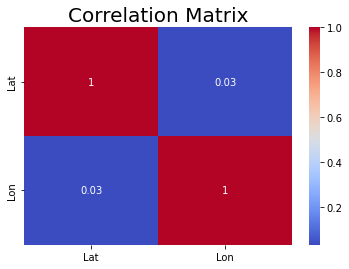

In [10]:
def corr_mat(uber, numeric_columns, width, height):
    from pyspark.mllib.stat import Statistics

    numeric_df = uber.select(numeric_columns)
    feature_vector = numeric_df.rdd.map(lambda row: row[0:])
    corr_matrix = Statistics.corr(feature_vector, method="pearson")

    corr_matrix_df = pd.DataFrame(corr_matrix)
    corr_matrix_df.index, corr_matrix_df.columns = numeric_columns, numeric_columns
    # display(corr_matrix_df)

    # Plotting
    import seaborn as sns

    plt.figure(figsize=(width, height))
    sns.heatmap(corr_matrix_df, annot=True, cmap='coolwarm')
    plt.title('Correlation Matrix', fontsize=20)
    plt.show()

corr_mat(uber, numeric_columns, 6, 4)


## Convert string to numerical

In [11]:
from pyspark.ml.feature import StringIndexer

string_columns_index = [column + '_index' for column in string_columns]
stringIndexer = StringIndexer().setInputCols(string_columns).setOutputCols(string_columns_index)
string_indexer_model = stringIndexer.fit(uber)
df = string_indexer_model.transform(uber)

for column in string_columns:
    df = df.drop(column)

df.show()


+-------+--------+---------------+----------+
|    Lat|     Lon|Date/Time_index|Base_index|
+-------+--------+---------------+----------+
|40.7366|-73.9906|        20173.0|       4.0|
| 40.726|-73.9918|        34403.0|       4.0|
|40.7209|-74.0507|        25098.0|       4.0|
|40.7387|-73.9856|        25098.0|       4.0|
|40.7323|-74.0077|        25098.0|       4.0|
|40.7349|-74.0033|        29513.0|       4.0|
|40.7279|-73.9542|        20174.0|       4.0|
| 40.721|-73.9937|        29515.0|       4.0|
|40.7195| -74.006|        26643.0|       4.0|
|40.7448|-73.9799|        29516.0|       4.0|
|40.7399|-74.0057|        32031.0|       4.0|
|40.7651|-73.9683|        29518.0|       4.0|
|40.7354|-74.0081|        30819.0|       4.0|
|40.7339|-74.0028|        20175.0|       4.0|
|40.7364|-74.0301|        20175.0|       4.0|
|40.7364|-74.0301|        20175.0|       4.0|
|40.7252|-73.9516|        33228.0|       4.0|
|40.7433| -73.986|        33228.0|       4.0|
|40.7437|-73.9884|        26644.0|

## Correlation matrix with string indexes

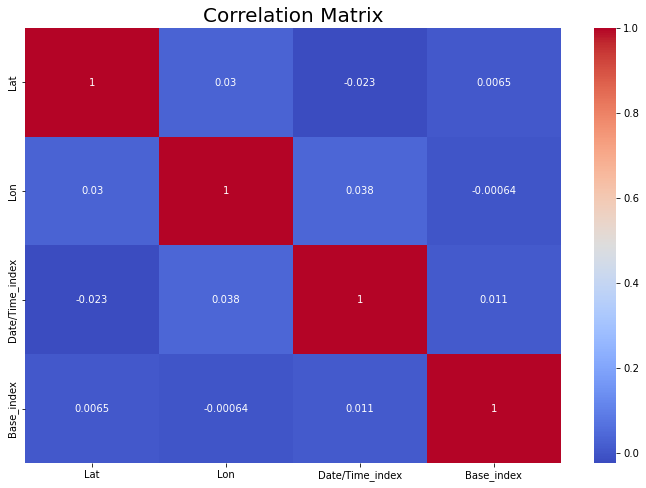

In [12]:
new_numeric_columns = numeric_columns + [column for column in df.columns if column.endswith('_index')]
corr_mat(df, new_numeric_columns, 12, 8)


## Contingency table

In [13]:
for column in string_columns:
    contingency_table = uber.crosstab(column, 'Base')
    display(contingency_table.toPandas())
    

,Date/Time_Base,B02512,B02598,B02617,B02682,B02764
0,8/9/2014 22:00:00,2,7,13,5,1
1,8/19/2014 19:13:00,2,3,14,2,2
2,8/31/2014 17:53:00,0,8,14,3,1
3,8/27/2014 12:10:00,1,4,11,7,6
4,8/19/2014 10:29:00,0,12,14,7,3
...,...,...,...,...,...,...
44427,8/12/2014 9:44:00,1,5,8,6,2
44428,8/3/2014 19:20:00,2,7,9,4,0
44429,8/17/2014 13:22:00,1,4,7,1,0
44430,8/8/2014 2:03:00,0,1,3,0,0


,Base_Base,B02512,B02598,B02617,B02682,B02764
0,B02617,0,0,355803,0,0
1,B02764,0,0,0,0,48591
2,B02512,31472,0,0,0,0
3,B02598,0,220129,0,0,0
4,B02682,0,0,0,173280,0


## KDE (Distribution), Histogram, Boxplot

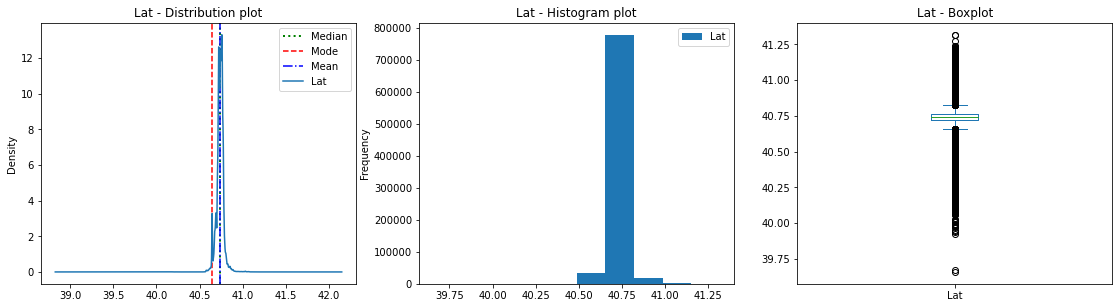

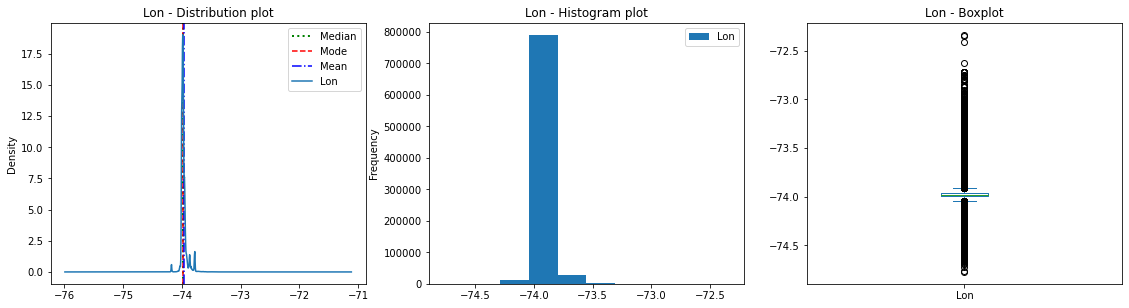

In [14]:
def three_plots(uber):
    for i, column in enumerate(numeric_columns):
        fig, axs = plt.subplots(1, 3, figsize=(6.4*3, 4.8))
        pdf = uber.select(column).toPandas()

        mean_value = uber.select(mean(column)).collect()[0][0]
        mode_value = uber.groupBy(column).count().sort(desc("count")).select(col(column)).collect()[0][0]
        median = uber.approxQuantile(column, [0.5], 0.01)[0]

        axs[0].set_title(column + " - Distribution plot")
        axs[0].axvline(median, color='green', label='Median', linestyle=':', linewidth=2)
        axs[0].axvline(mode_value, color='red', label='Mode', linestyle='--')
        axs[0].axvline(mean_value, color='blue', label='Mean', linestyle='-.')
        axs[0].legend()
        pdf.plot.kde(ax=axs[0])

        axs[1].set_title(column + " - Histogram plot")
        pdf.plot.hist(ax=axs[1])
        
        axs[2].set_title(column + " - Boxplot")
        pdf.plot.box(ax=axs[2])

        plt.show()

three_plots(uber)


## Scatterplots

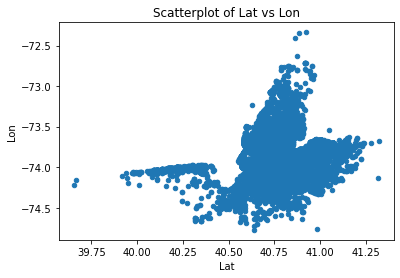

In [15]:
pdf = uber.toPandas()
pdf.plot.scatter(x='Lat', y='Lon')
plt.title(f'Scatterplot of Lat vs Lon')
plt.show()

# pdf.plot.scatter(x='Lon', y='Lat')
# plt.title(f'Scatterplot of Lon vs Lat')
# plt.show()
